<a href="https://colab.research.google.com/github/MDankloff/Cluster-Bias-Disco/blob/main/BAF_Reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install google-colab

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
!pip install aequitas

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 13.7 MB/s eta 0:00:00


In [ ]:
!pip install pyarrow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/feedzai/bank-account-fraud.git

Cloning into 'bank-account-fraud'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 110 (delta 54), reused 64 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 1.13 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import yaml              # Read hyperparameter space configuration
import glob
import os

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder # Categorical encoding for LGBM models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics

from aequitas.group import Group                # Fairness metrics
from random_search import RandomValueTrial, suggest_callable_hyperparams  # Random search wrapper methods

In [ ]:
import yaml

# If the file is within a subdirectory, for example, named "config":
with open("/content/lightgbm_hyperparameter_space.yaml", "r") as file:
    # Remove the 'Loader' argument
    hyperparam_space = yaml.safe_load(file)

# Load Bank Account Fraud (BAF) Tabular Dataset Suite

use this code to create parquet files

In [ ]:
'''base_path = '/content/drive/MyDrive/Mirthe Supervision Map /Paper 3a: FC Bias Disco/BAF'

# Dictionary mapping dataset names to CSV paths
datasets_paths = {
    "Base": base_path + "/Base.csv",
    "Variant I": base_path + "/Variant I.csv",
    "Variant II": base_path + "/Variant II.csv",
    "Variant III": base_path + "/Variant III.csv",
    "Variant IV": base_path + "/Variant IV.csv",
    "Variant V": base_path + "/Variant V.csv",
}

# Convert CSV files to Parquet
for variant, csv_path in datasets_paths.items():
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Create the corresponding Parquet path by replacing .csv with .parquet
    parquet_path = csv_path.replace(".csv", ".parquet")

    # Save the DataFrame as a Parquet file
    df.to_parquet(parquet_path, engine='pyarrow')

    print(f"Converted {variant} to Parquet at {parquet_path}")'''


In [ ]:
base_path = '/content/drive/MyDrive/Mirthe Supervision Map /Paper 3a: FC Bias Disco/BAF'

extension = "parquet" #for smaller "parquet" depending on the downloaded file
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalance disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalance disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [36]:
datasets = {key: read_dataset(path) for key, path in datasets_paths.items()}

In [ ]:
#dataframes["Variant I"].info()

# Find best model

5 LightGBM models with the best results (evaluation metrics accuracy or AUC) were chosen. These were trained and evaluated on the original data and involved testing 200 different sets hps (e.g., learning rate, number of leaves, max depth) that control how the model learns.
The HP configurations were chosen through random search.

In [ ]:
# The expected structure is the following:
hyperparam_space

{'LightGBM': {'classpath': 'lightgbm.LGBMClassifier',
  'kwargs': {'n_estimators': {'type': 'int',
    'range': [20, 10000],
    'log': True},
   'max_depth': {'type': 'int', 'range': [3, 30]},
   'learning_rate': {'type': 'float', 'range': [0.02, 0.1], 'log': True},
   'num_leaves': {'type': 'int', 'range': [10, 100], 'log': True},
   'boosting_type': ['gbdt', 'goss'],
   'min_data_in_leaf': {'type': 'int', 'range': [5, 200], 'log': True},
   'max_bin': {'type': 'int', 'range': [100, 500]},
   'enable_bundle': [True, False]}}}

In [35]:
# Testing a random search suggestion:
trial = RandomValueTrial(seed=1)
suggest_callable_hyperparams(trial, hyperparam_space)

{'classpath': 'lightgbm.LGBMClassifier',
 'n_estimators': 263,
 'max_depth': 23,
 'learning_rate': 0.020003681922217444,
 'num_leaves': 19,
 'boosting_type': 'gbdt',
 'min_data_in_leaf': 9,
 'max_bin': 238,
 'enable_bundle': False}

In [ ]:
# Define the label field and categorical columns.
label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

In [ ]:
# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_dfs = {key: df[df["month"]<6].sample(frac=1, replace=False) for key, df in datasets.items()}
test_dfs = {key: df[df["month"]>=6].sample(frac=1, replace=False) for key, df in datasets.items()}

pre-process step

In [ ]:
# Encode the categorical variables in the datasets to integers.
# This is expected by LGBM (or columns with the `categorical` data type).

for name in datasets.keys():  # For each dataset in the suite
    train = train_dfs[name]
    test = test_dfs[name]

    for feat in categorical_features:
        encoder = LabelEncoder()
        encoder.fit(train[feat])  # Fit an encoder to the train set.
        train[feat] = encoder.transform(train[feat])  # Transform train set.
        test[feat] = encoder.transform(test[feat])    # Transform test set.

In [18]:
# Cell with train loop for hyperparameter tuning of an LGBM classifier across variant datasets

# Define number of trials in Random search
n_trials= 10 #100
# Random state for sampling seeds
np.random.seed(42)
# Seeds for the random search sampling algorithm
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

# Variable to store the results for each run
runs = {}

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    #del test_hyperparams["classpath"] # Remove unnecessary key in hyperparaemters

    # Update list of tested hyperparameters.
    prev_hyperparams = runs.get("hyperparams", [])
    prev_hyperparams.append(test_hyperparams)
    runs["hyperparams"] = prev_hyperparams

    for dataset_name in datasets.keys():  # Run hyperparameters on all variants of datastes
        model = lgbm.LGBMClassifier(n_jobs=10, **test_hyperparams)  # Instantiate LGBM Model
        X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_train = train_dfs[dataset_name]["fraud_bool"]
        X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
        y_test = test_dfs[dataset_name]["fraud_bool"]
        # Fit model to training data.
        model.fit(X_train, y_train, categorical_feature=categorical_features)
        # Obtain predictions in test data.
        predictions = model.predict_proba(X_test)[:, 1]

        # Obtain ROC curve for the predictions.
        fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
        # Obtain threshold and recall. We select 5% FPR as threshold
        threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
        recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

        # Binarize predictions for Aequitas.
        preds_binary = (predictions > threshold).astype(int)

        # Create a dataframe with protected group column, predictions and labels.
        # Here, we select age>=50 as threshold.
        aequitas_df = pd.DataFrame(
            {
                "age": (X_test["customer_age"]>=50).map({True: "Older", False: "Younger"}),
                "preds": preds_binary,
                "y": y_test.values
            }
        )

        # Obtain FPR results for different groups.
        g = Group()
        aequitas_results = g.get_crosstabs(aequitas_df, attr_cols=["age"], score_col="preds", label_col="y")[0]

        # Store the results for the trained model
        results = {}
        results["recall"] = recall
        results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
        results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
        results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
        results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

        # Store the results in the runs variable
        prev_runs = runs.get(dataset_name, [])
        prev_runs.append(results)
        runs[dataset_name] = prev_runs

Streaminguitvoer ingekort tot de laatste 5000 regels.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [37]:
# Create a dataframe with the results for each model in each dataset.
rs_results = pd.DataFrame(runs)

In [34]:
rs_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   hyperparams  10 non-null     object
 1   Base         10 non-null     object
 2   Variant I    10 non-null     object
 3   Variant II   10 non-null     object
 4   Variant III  10 non-null     object
 5   Variant IV   10 non-null     object
 6   Variant V    10 non-null     object
dtypes: object(7)
memory usage: 688.0+ bytes


In [22]:
# Helper method to obtain the metric values for a given model.
def get_results(results, variant, metric):
    col = results[variant]
    values = []
    for idx, val in col.items():#iteritems():
        values.append(val[metric])
    return values

In [23]:
# Obtain the relevant metrics to plots from the dataframe.
variants = list(datasets_paths.keys())

plot_results = {"Variant": [], "Recall": [], "FPR Ratio": []}

for variant in variants:
    plot_results["Recall"] += get_results(rs_results, variant, "recall")
    # Obtain the FPR if both groups.
    for fpr_younger, fpr_older in zip(get_results(rs_results, variant, "fpr Younger"), get_results(rs_results, variant, "fpr Older")):
        # Calculate FPR ratio as higher fpr / lower fpr
        if fpr_younger > fpr_older:
            plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
        else:
            plot_results["FPR Ratio"] += [fpr_younger/fpr_older]
    plot_results["Variant"] += [variant] * len(get_results(rs_results, variant, "recall"))

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

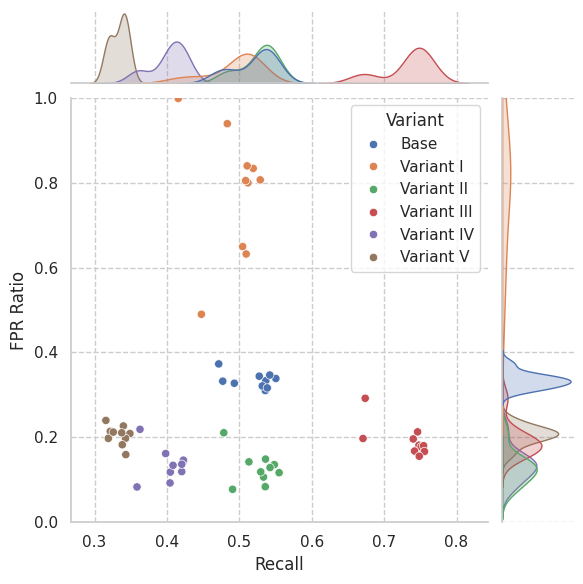

In [24]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", hue="Variant")
plt.ylim((0,1));

In [27]:
import copy
# Create the final plot. Highlight the top models:
top_n = 5
top_models_base = plot_results.loc[plot_results['Variant'] == 'Base'].sort_values('Recall', ascending=False).head(top_n).index.values
top_models = copy.deepcopy(top_models_base)#deepcopy(top_models_base)
for i in range(1, 6):
    top_models = np.r_[top_models, top_models_base + (100 * i)]

plot_results['index'] = plot_results.index
plot_results['is_top'] = plot_results.apply(lambda x: 1 if x['index'] in top_models else 0, axis=1)

<ipython-input-28-7f9e5eee13bd>:16: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
<ipython-input-28-7f9e5eee13bd>:17: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)


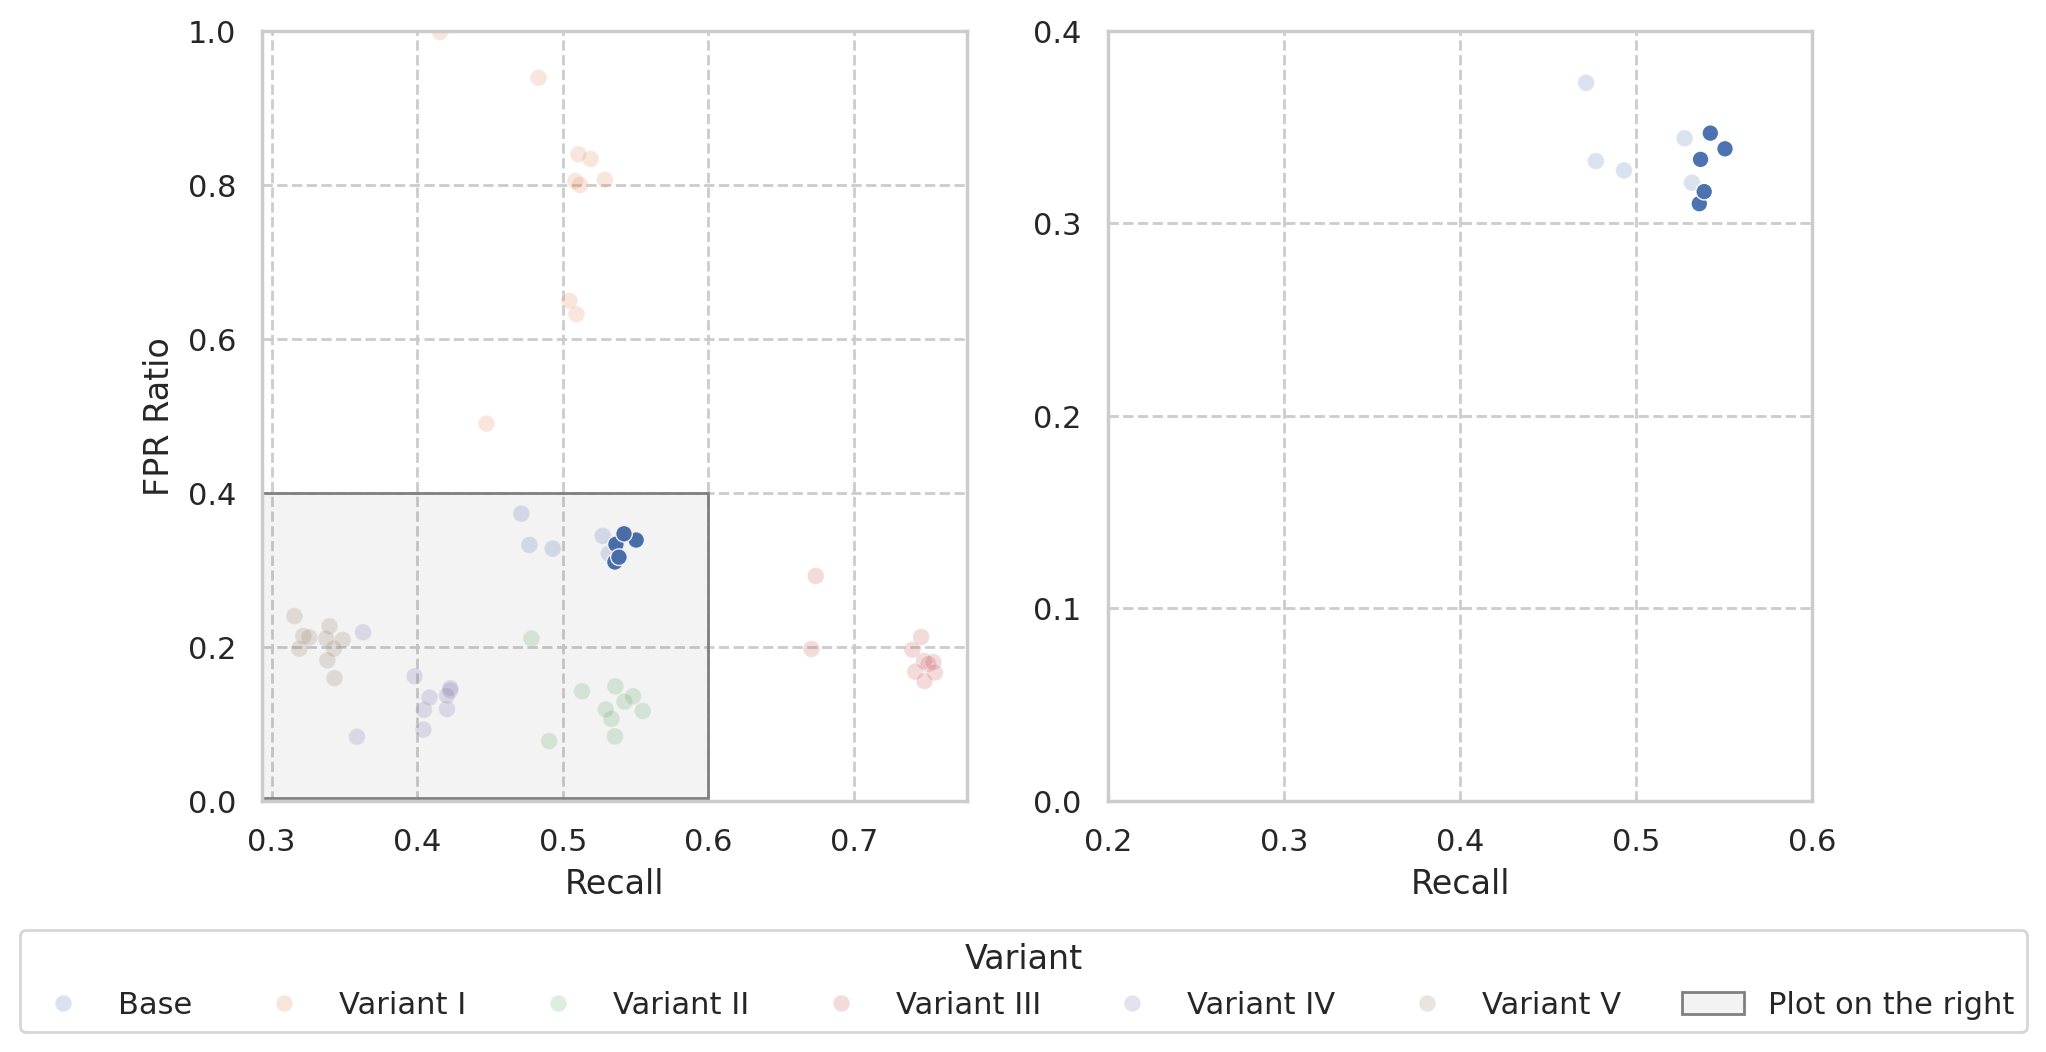

In [28]:
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.alpha":0.1})
DPI = 200
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['figure.figsize'] = (10,5)

fig, (ax1, ax2) = plt.subplots(1, 2)

# LEFT PLOT
sns.scatterplot(ax=ax1, data=plot_results.loc[(~plot_results.index.isin(top_models)), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2)
sns.scatterplot(ax=ax1, data=plot_results.loc[plot_results.index.isin(top_models), :], x="Recall", y="FPR Ratio", hue="Variant", legend=False)
ax1.set(
    ylim=(0,1)
)

# RIGHT PLOT
sns.scatterplot(ax=ax2, data=plot_results.loc[(~plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", alpha=0.2, palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
sns.scatterplot(ax=ax2, data=plot_results.loc[(plot_results.index.isin(top_models)) & (plot_results["Variant"].isin(["Base", "Type II", "Type V", "Type IV"])), :], x="Recall", y="FPR Ratio", hue="Variant", palette=[sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4], sns.color_palette()[5]], legend=False)
ax2.set(
    ylim=(0,0.4),
    ylabel="",
    xticks=np.arange(0.2, 0.8, 0.1),
    yticks=np.arange(0, 0.5, 0.1),
    xlim=(0.2, 0.6),
)

rect = plt.Rectangle((0.2, 0.004), 0.4, 0.396, facecolor=(0.1, 0.1, 0.1, 0.05), edgecolor="grey", linestyle="-")
ax1.add_patch(rect)
handles, labels = ax1.get_legend_handles_labels()
handles = list(handles) + [rect]
labels = list(labels) + ["Plot on the right"]
ax1.legend(handles, labels, title="Variant")

sns.move_legend(
    ax1,
    loc="lower center",
    bbox_to_anchor=[1.08, -0.32],
    ncol=7
)

save the best models

In [40]:
import joblib

# Create a folder to save the models if it doesn't exist
models_path = "top_models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

# Get the variant names from the datasets
variant_names = list(datasets_paths.keys())

# Iterate over the top models and save them
for idx in top_models:
    # Determine which variant this index corresponds to
    variant_index = idx // 100  # Assuming each variant has 100 models
    relative_idx = idx % 100     # Get the index within the variant

    # Get the corresponding variant name
    variant_name = variant_names[variant_index]

    # Access the model from the runs dictionary
    model = runs[variant_name][relative_idx]

    # Save the model using joblib
    joblib.dump(model, os.path.join(models_path, f"model_{variant_name}_{relative_idx}.pkl"))

print(f"Saved top models successfully in '{models_path}' directory.")


Saved top models successfully in 'top_models' directory.


In [39]:
print("Plot results indices:", plot_results.index.tolist())
print("Top models:", top_models)

Plot results indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Top models: [  4   7   8   0   3 104 107 108 100 103 204 207 208 200 203 304 307 308
 300 303 404 407 408 400 403 504 507 508 500 503]
